In [34]:
import csv
import pandas as pd
import math
import numpy as np
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

In [35]:
def showProgressPercentage(current, total) : 
    prevPercentage = int ((current-1) / total * 100)
    currPrecentage = int (current / total * 100)
    progress = 0
    if (currPrecentage >= 90 and prevPercentage < 90) : 
        progress = 90
    elif (currPrecentage >= 80 and prevPercentage < 80) : 
        progress = 80 
    elif (currPrecentage >= 70 and prevPercentage < 70) : 
        progress = 70 
    elif (currPrecentage >= 60 and prevPercentage < 60) : 
        progress = 60 
    elif (currPrecentage >= 50 and prevPercentage < 50) : 
        progress = 50 
    elif (currPrecentage >= 40 and prevPercentage < 40) : 
        progress = 40 
    elif (currPrecentage >= 30 and prevPercentage < 30) : 
        progress = 30 
    elif (currPrecentage >= 20 and prevPercentage < 20) : 
        progress = 20 
    elif (currPrecentage >= 10 and prevPercentage < 10) : 
        progress = 10 
    if (progress > 0) :
        print(progress, "%")
        
def mapDayToNumber(day) :
    dayOfWeeks = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    for i in range(len(dayOfWeeks)) : 
        if (dayOfWeeks[i] == day) : 
            return i+1
    return 0
def mapTimeToNumber(time) :
    times = ["12AM", "01AM", "02AM", "03AM", "04AM", "05AM", "06AM", "07AM", "08AM", "09AM", "10AM", "11AM", "12PM", "01PM", "02PM", "03PM", "04PM", "05PM", "06PM", "07PM", "08PM", "09PM", "10PM", "11PM"]
    for i in range(len(times)) : 
        if (times[i] == time) : 
            return i
    return 0
    
def fetchDay(createTime)  :
    [dayOfWeek, time] = createTime.split(' ')
    return mapDayToNumber(dayOfWeek)

def fetchTime(createTime) : 
    [dayOfWeek, time] = createTime.split(' ')
    return mapTimeToNumber(time)

def correctThePrice(oldPrice) : 
    newPrice = oldPrice
    if (4500 < oldPrice < 10000) : 
        newPrice = -11
#         newPrice = oldPrice * 10
    
    elif (10 <= oldPrice <= 4500) : 
        newPrice = oldPrice * 1000
        
    elif (0 < oldPrice < 10) : 
        newPrice = -11
#         newPrice = oldPrice * 1000000
    
    return newPrice

def getAveragePricesPerBrands(df, brands) : 
    sums = { i : 0 for i in brands }
    repeats = { i : 0 for i in brands }
    avgs = { i : 0 for i in brands }
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price != -1) : 
            sums[dfRow['brand']] += price
            repeats[dfRow['brand']] += 1
    for brand in brands : 
        avgs[brand] = int(sums[brand] / repeats[brand])
    return avgs
        
    

In [47]:
def getProcessedNonTextData(dataFile, brandEncType = "onehot", cityEncType = "onehot") : 
    data = []
    valData = []
    targetData = []
    col_list = ["brand", "city", "title", "desc", "image_count", "created_at", "price"]
    df = pd.read_csv(dataFile, usecols=col_list)
    
    print("preprocessing started...")
    
    if (brandEncType == "onehot") :
        df = pd.concat([df,pd.get_dummies(df['brand'], prefix = "brand")],axis=1)
    
    print("brand onehot encoding done...")
        
    if (cityEncType == "onehot") :
        df = pd.concat([df,pd.get_dummies(df['city'], prefix = "city")],axis=1)
        
    print("city onehot encoding done...")
    
    df['dayOfweek'] = df.apply(lambda row : fetchDay(row['created_at']), axis = 1) 
    df['time'] = df.apply(lambda row : fetchTime(row['created_at']), axis = 1) 
    del df['created_at']
    
    print("time preprocessing done...")
    
    df['price'] = df.apply(lambda row : correctThePrice(row['price']), axis = 1)
    df = df.loc[df['price'] > -10]
    
    brands = df.brand.unique()
    avgPrices = getAveragePricesPerBrands(df, brands)
    
    print("price correction done, average price per every brand calculated...")
    
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price == -1) : 
            price = avgPrices[dfRow['brand']]
        targetData.append(price)
        del dfRow['price']
        del dfRow['brand']
        del dfRow['city']  
        data.append(dfRow)
    
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price == -1) : 
            price = avgPrices[dfRow['brand']]
        del dfRow['price']
        del dfRow['brand']
        del dfRow['city']  
        del dfRow['title']
        del dfRow['desc']
        valData.append(dfRow)
        
    
    labels = list(df)
    labels.remove('price')
    labels.remove('brand')
    labels.remove('city')
    valLabels = list(df)
    valLabels.remove('price')
    valLabels.remove('brand')
    valLabels.remove('city')
    valLabels.remove('title')
    valLabels.remove('desc')
    
    print("part1 done.")
    return [df, data, valData, targetData, labels, valLabels]

In [48]:
[df, data, valData, targetData, labels, valLabels] = getProcessedNonTextData("mobile_phone_dataset.csv")

preprocessing started...
brand onehot encoding done...
city onehot encoding done...
time preprocessing done...
price correction done, average price per every brand calculated...
part1 done.


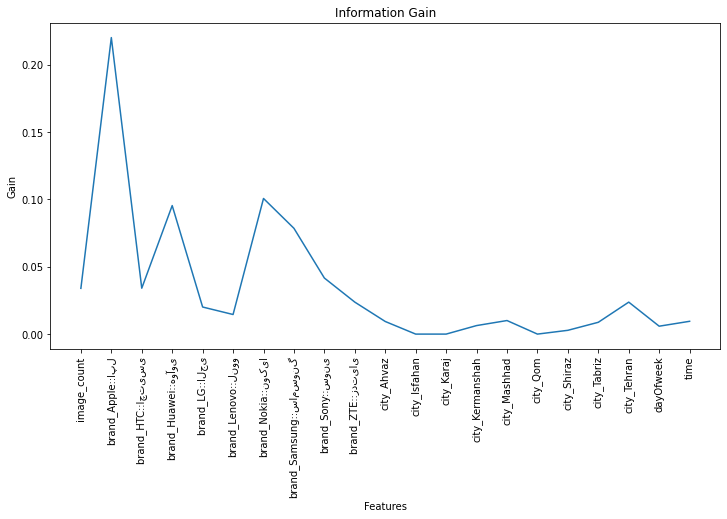

In [49]:
informationGains = mutual_info_classif(valData, targetData)
def showInformationGains(labels) :
    plt.figure(figsize=(12, 6))
    plt.plot(informationGains) 
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.xlabel('Features') 
    plt.ylabel('Gain') 
    plt.title('Information Gain') 

    plt.show()
showInformationGains(valLabels)

In [50]:
import hazm
from hazm.WordTokenizer import WordTokenizer
from nltk.corpus import stopwords 
from hazm.Lemmatizer import Lemmatizer
from hazm.Normalizer import Normalizer
import operator

stop_words_fa = set(hazm.utils.stopwords_list()) 
stop_words_en = set(stopwords.words('english')) 
punctuations = {",", ".", "(", ")", ";", ":", "؛", "،"}
stop_words = stop_words_fa.union(stop_words_en)
stop_words = stop_words.union(punctuations)

normalizer = Normalizer()
tokenizer = WordTokenizer()
lemmatizer = Lemmatizer()
# print(stop_words)

def lowerAllCharacters(context) :
    context = context.lower()
    return context

def normalizeContext(context) : 
    context = normalizer.affix_spacing(context)
    context = normalizer.character_refinement(context)
    context = normalizer.punctuation_spacing(context)
    return context

def removeStopWordsAndPunctuations(context) : 
#     tokenizer = RegexpTokenizer(r'\w+')
    context = tokenizer.tokenize(context)
    
    filtered_sentence = [] 
    
    for w in context: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def lemmatizeWords(wordList) : 
    for i in range(len(wordList)):
        wordList[i] = lemmatizer.lemmatize(wordList[i])
            
    return wordList

def getProcessedWords(context) : 
    context = lowerAllCharacters(context)
    context = normalizeContext(context)
#     wordList = []
    wordList = removeStopWordsAndPunctuations(context)
    wordList = lemmatizeWords(wordList)
    return wordList
    

In [51]:
def getProcessedTextData(data, rowName) : 
    totalWords = {}
    wordLists = []
    for row in data :
        wordList = getProcessedWords(row[rowName])
        wordLists.append(wordList)
        for word in wordList : 
            if word in totalWords : 
                totalWords[word] += 1
            else :
                totalWords[word] = 1
#         print(i)
#         print(row['title'])
#         print(wordList)
#         print("_____________________________________________________")
    return [wordLists, totalWords]

In [52]:
[titleWordLists, totalTitleWords] = getProcessedTextData(data, 'title')

In [53]:
[descWordLists, totalDescWords] = getProcessedTextData(data, 'desc')

In [54]:
sortedTitleWords = sorted(totalTitleWords.items(),key=operator.itemgetter(1),reverse=True)
sortedDescWords = sorted(totalDescWords.items(),key=operator.itemgetter(1),reverse=True)

# idx = 0 #150
# for i in sortedTitleWords :
#     idx += 1
#     print(idx, i)

# idx = 0 #100
# for i in sortedDescWords :
#     idx += 1
#     print(idx, i)

In [55]:
def getImpWords(wordList, amount) : 
    words = set()
    i = 0
    for word in wordList :
        if (i >= amount) : 
            break
        words.add(word[0])
        i += 1
    return words

In [56]:
titleImpWords = getImpWords(sortedTitleWords, 45)
descImpWords = getImpWords(sortedDescWords, 30)

In [57]:
# print(titleImpWords)
# print(descImpWords)
def checkFeature(i, feature, wordList) : 
    if (feature in wordList[i]) : 
        return 1
    return 0

In [58]:
def rowIndex(row):
    return row.name
def addFeatures(prefix, df, impWords, wordLists) :
    i = 0
    totalSize = len(impWords)
    df["rowIndex"] = list(range(len(df)))
    for feature in impWords : 
        df[prefix + feature] = df.apply(lambda row : checkFeature(row['rowIndex'], feature, wordLists), axis = 1) 
        i += 1
        showProgressPercentage(i, totalSize)
    return df

In [59]:
df2 = addFeatures("title_", df, titleImpWords, titleWordLists)

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


In [60]:
df2 = addFeatures("desc_", df, descImpWords, descWordLists)

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


In [61]:
def getDatas(df) :
    data = []
    targetData = []
    brands = df.brand.unique()
    avgPrices = getAveragePricesPerBrands(df, brands)
    
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price == -1) : 
            price = avgPrices[dfRow['brand']]
        targetData.append(price)
#         print(dfRow["desc_lla"])
        del dfRow['price']
        del dfRow['brand']
        del dfRow['city']
        del dfRow['title']
        del dfRow['desc']
        data.append(dfRow)
    
    labels = list(df)
    labels.remove('price')
    labels.remove('brand')
    labels.remove('city')
    labels.remove('title')
    labels.remove('desc')
    print("preprocessing done.")
    return [df, data, targetData, labels]

In [17]:
[df2, data2, targetData2, labels2] = getDatas(df)

preprocessing done.


In [20]:
informationGains = mutual_info_classif(data, targetData)